In [ ]:
#Drive connect

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Evaluate on Test Data

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import os

In [ ]:
# Data Preprocessing

train_dir = "/content/drive/MyDrive/CTS project/pre_processed_brain-tumor-dataset/Training"
val_dir   = "/content/drive/MyDrive/CTS project/pre_processed_brain-tumor-dataset/Validation"
test_dir  = "/content/drive/MyDrive/CTS project/pre_processed_brain-tumor-dataset/Testing"

IMG_SIZE = 224
BATCH_SIZE = 32

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 5712 images belonging to 4 classes.
Found 1055 images belonging to 4 classes.
Found 256 images belonging to 4 classes.


In [ ]:
# Build model (MobileNetV3 base)
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

base_model = MobileNetV3Small(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False   # freeze backbone for initial training

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation="softmax", kernel_regularizer=l2(0.001))(x)

model = Model(inputs=base_model.input, outputs=output)
model.summary()


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 1,087,860 (4.15 MB)

 Trainable params: 148,740 (581.02 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [ ]:
# Custom Metrics

import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import time

def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float'))
    fp = tf.reduce_sum(tf.cast((1-y_true) * y_pred, 'float'))
    fn = tf.reduce_sum(tf.cast(y_true * (1-y_pred), 'float'))

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    return 2*((precision*recall)/(precision+recall+tf.keras.backend.epsilon()))

class CustomLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.epoch_start
        print(f"\nEpoch {epoch+1}/{self.params['epochs']} | Time: {elapsed:.2f}s")
        print(f"Train Loss: {logs['loss']:.4f} | "
              f"Acc: {logs['accuracy']:.4f} | "
              f"Precision: {logs['precision']:.4f} | "
              f"Recall: {logs['recall']:.4f} | "
              f"F1: {logs['f1_score']:.4f}")
        print(f"Val   Loss: {logs['val_loss']:.4f} | "
              f"Acc: {logs['val_accuracy']:.4f} | "
              f"Precision: {logs['val_precision']:.4f} | "
              f"Recall: {logs['val_recall']:.4f} | "
              f"F1: {logs['val_f1_score']:.4f}")
        print("-"*90)


In [ ]:
# Compile Model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy",
             Precision(name="precision"),
             Recall(name="recall"),
             f1_score]
)


In [ ]:
# EarlyStopping Callback

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


In [ ]:
# Train Model

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[CustomLogger(), early_stopping]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.4787 - f1_score: 0.4045 - loss: 1.6227 - precision: 0.5444 - recall: 0.3279 
Epoch 1/50 | Time: 2943.64s
Train Loss: 1.3389 | Acc: 0.5968 | Precision: 0.6932 | Recall: 0.4611 | F1: 0.5447
Val   Loss: 0.9597 | Acc: 0.7791 | Precision: 0.8564 | Recall: 0.6559 | F1: 0.7417
------------------------------------------------------------------------------------------
179/179 ━━━━━━━━━━━━━━━━━━━━ 2944s 16s/step - accuracy: 0.4794 - f1_score: 0.4052 - loss: 1.6212 - precision: 0.5452 - recall: 0.3286 - val_accuracy: 0.7791 - val_f1_score: 0.7417 - val_loss: 0.9597 - val_precision: 0.8564 - val_recall: 0.6559
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.7671 - f1_score: 0.7422 - loss: 0.9713 - precision: 0.8326 - recall: 0.6717
Epoch 2/50 | Time: 90.29s
Train Loss: 0.9220 | Acc: 0.7829 | Precision: 0.8413 | Recall: 0.6999 | F1: 0.7626
Val   Loss: 0.8568 | Acc: 0.8114 | Precision: 0.8498 | Recall: 0.7564 | F1:

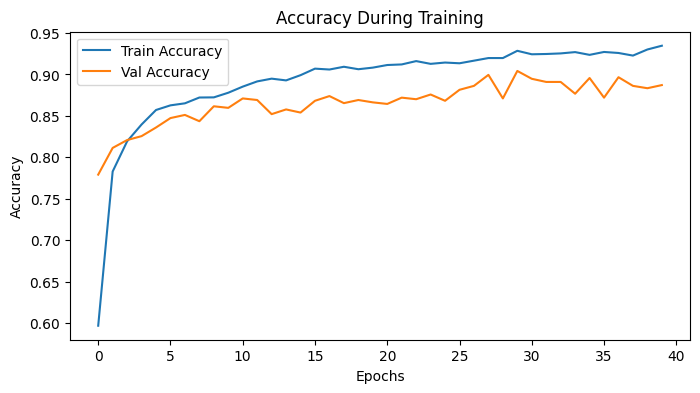

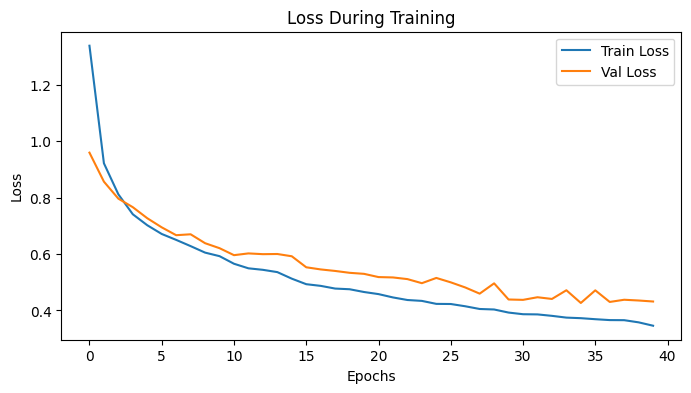

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras.preprocessing import image

img_path = "/content/drive/MyDrive/CTS project/pre_processed_brain-tumor-dataset/Testing/glioma/Te-gl_0133.jpg"  # sample image path
img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
pred_class = np.argmax(pred, axis=1)

print(f"Predicted Class: {list(test_generator.class_indices.keys())[pred_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted Class: glioma


In [ ]:
from tensorflow.keras.preprocessing import image

img_path = "/content/drive/MyDrive/CTS project/pre_processed_brain-tumor-dataset/Testing/pituitary/Te-pi_0150.jpg"  # sample image path
img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
pred_class = np.argmax(pred, axis=1)

print(f"Predicted Class: {list(test_generator.class_indices.keys())[pred_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Class: pituitary


In [ ]:
from tensorflow.keras.preprocessing import image

img_path = "/content/drive/MyDrive/CTS project/pre_processed_brain-tumor-dataset/Testing/notumor/Te-no_0273.jpg"  # sample image path
img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
pred_class = np.argmax(pred, axis=1)

print(f"Predicted Class: {list(test_generator.class_indices.keys())[pred_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted Class: notumor


In [ ]:
from tensorflow.keras.preprocessing import image

img_path = "/content/drive/MyDrive/CTS project/pre_processed_brain-tumor-dataset/Testing/meningioma/Te-me_0025.jpg"  # sample image path
img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
pred_class = np.argmax(pred, axis=1)

print(f"Predicted Class: {list(test_generator.class_indices.keys())[pred_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted Class: meningioma


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 88s 12s/step


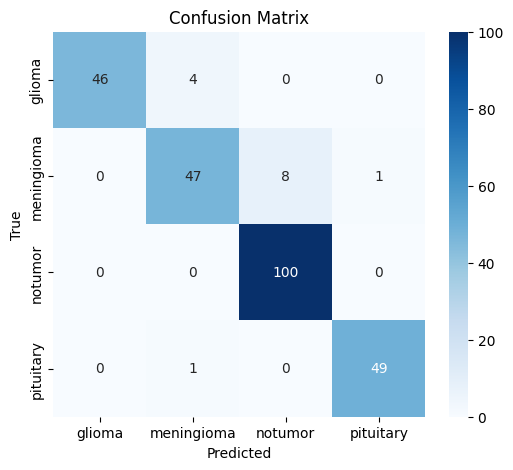


Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.92      0.96        50
  meningioma       0.90      0.84      0.87        56
     notumor       0.93      1.00      0.96       100
   pituitary       0.98      0.98      0.98        50

    accuracy                           0.95       256
   macro avg       0.95      0.93      0.94       256
weighted avg       0.95      0.95      0.94       256



In [ ]:
# Confusion Matrix & Classification Report

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on test data
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.9229 - f1_score: 0.9194 - loss: 0.3938 - precision: 0.9224 - recall: 0.9165


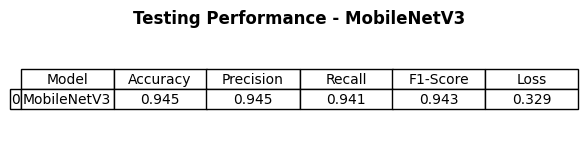

         Model  Accuracy  Precision  Recall  F1-Score   Loss
0  MobileNetV3     0.945      0.945   0.941     0.943  0.329


In [ ]:
# Evaluate on Test Data

import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table

test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(test_generator)

# Create a DataFrame for performance metrics
results_df = pd.DataFrame({
    "Model": ["MobileNetV3"],
    "Accuracy": [round(test_acc, 3)],
    "Precision": [round(test_precision, 3)],
    "Recall": [round(test_recall, 3)],
    "F1-Score": [round(test_f1, 3)],
    "Loss": [round(test_loss, 3)]
})

# Display results as a table
fig, ax = plt.subplots(figsize=(6, 1.5))
ax.axis('tight')
ax.axis('off')
tbl = table(ax, results_df, loc='center', cellLoc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2)

plt.title("Testing Performance - MobileNetV3", fontsize=12, fontweight='bold')
plt.show()

# Print DataFrame as well
print(results_df)


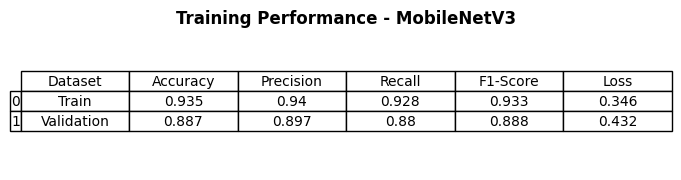

In [ ]:
# Training Performance Summary
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table


# Get the last epoch metrics from training history
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]
train_precision = history.history['precision'][-1]
val_precision = history.history['val_precision'][-1]
train_recall = history.history['recall'][-1]
val_recall = history.history['val_recall'][-1]
train_f1 = history.history['f1_score'][-1]
val_f1 = history.history['val_f1_score'][-1]

# Create a DataFrame for training & validation performance
train_results_df = pd.DataFrame({
    "Dataset": ["Train", "Validation"],
    "Accuracy": [round(train_acc, 3), round(val_acc, 3)],
    "Precision": [round(train_precision, 3), round(val_precision, 3)],
    "Recall": [round(train_recall, 3), round(val_recall, 3)],
    "F1-Score": [round(train_f1, 3), round(val_f1, 3)],
    "Loss": [round(train_loss, 3), round(val_loss, 3)]
})

# Plot as a table
fig, ax = plt.subplots(figsize=(7, 1.8))
ax.axis('tight')
ax.axis('off')
tbl = table(ax, train_results_df, loc='center', cellLoc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2)

plt.title("Training Performance - MobileNetV3", fontsize=12, fontweight='bold')
plt.show()


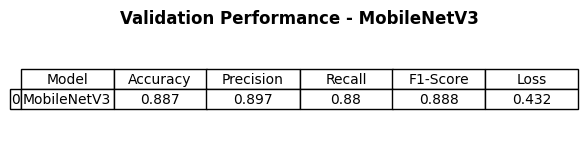

         Model  Accuracy  Precision  Recall  F1-Score   Loss
0  MobileNetV3     0.887      0.897    0.88     0.888  0.432


In [ ]:
# Validation Performance Summary

import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table


# Extract last epoch's validation metrics
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
val_precision = history.history['val_precision'][-1]
val_recall = history.history['val_recall'][-1]
val_f1 = history.history['val_f1_score'][-1]

# Create DataFrame
val_results_df = pd.DataFrame({
    "Model": ["MobileNetV3"],
    "Accuracy": [round(val_acc, 3)],
    "Precision": [round(val_precision, 3)],
    "Recall": [round(val_recall, 3)],
    "F1-Score": [round(val_f1, 3)],
    "Loss": [round(val_loss, 3)]
})

# Plot as a table
fig, ax = plt.subplots(figsize=(6, 1.5))
ax.axis('tight')
ax.axis('off')
tbl = table(ax, val_results_df, loc='center', cellLoc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2)

plt.title("Validation Performance - MobileNetV3", fontsize=12, fontweight='bold')
plt.show()

# Print DataFrame
print(val_results_df)


In [ ]:
# Save Model

# Save as .h5 format
model.save("/content/brain_tumor_mobilenetv3_l2.h5")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2

loaded_model = load_model(
    "/content/drive/MyDrive/CTS project/brain_tumor_model.keras",
    custom_objects={'f1_score': f1_score, 'l2': l2}
)


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Save Model

# Save as .keras format
model.save("/content/drive/MyDrive/CTS project/brain_tumor_model.keras")
print("✅ Model saved successfully at /content/drive/MyDrive/CTS project/brain_tumor_model.keras")

✅ Model saved successfully at /content/drive/MyDrive/CTS project/brain_tumor_model.keras


In [ ]:
# Evaluate Model on Test Data

test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(test_generator)
print(f"\n📊 Test Results:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9229 - f1_score: 0.9194 - loss: 0.3938 - precision: 0.9224 - recall: 0.9165

📊 Test Results:
Loss: 0.3286
Accuracy: 0.9453
Precision: 0.9451
Recall: 0.9414
F1 Score: 0.9432
